In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_dir = Path("data/huge_stock_market_dataset/")
results_dir = Path("results")

In [3]:
ts_info = pd.read_csv(dataset_dir / "selected.csv")
ts_info["ts_id"] = ts_info.index

In [4]:
horizon = 8
results = []
for results_type in ("pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"):
    for model in ("LSTM", "TCN", "cbr"):
        df = pd.read_csv(results_dir / f"{results_type}_{model}_h{horizon}.csv")
        df["model"] = model
        df["results_type"] = results_type
        results.append(df)
results = pd.concat(results)
results["model"].replace("cbr", "CatBoostRegressor", inplace=True)
results["results_type"].replace(["pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"],
                                ["train set", "QuantGAN synthetic data", "FourierFlow synthetic data", "RealNVP synthetic data", "TTS GAN synthetic data"], 
                                inplace=True)
results

,train,test,model,results_type
0,0.097664,0.618813,LSTM,train set
1,0.178904,0.888597,LSTM,train set
2,0.169664,0.793162,LSTM,train set
3,0.200256,0.758744,LSTM,train set
4,0.195375,0.637577,LSTM,train set
...,...,...,...,...
19,1.012060,0.683544,CatBoostRegressor,TTS GAN synthetic data
20,7.075217,3.598870,CatBoostRegressor,TTS GAN synthetic data
21,2.846970,2.290241,CatBoostRegressor,TTS GAN synthetic data
22,0.723327,0.678741,CatBoostRegressor,TTS GAN synthetic data


In [6]:
results_agg = results.groupby(by=["model", "results_type"], axis=0).agg(train=("train", "mean"), test=("test", "mean"))
results_agg

train      test
model             results_type                                  
CatBoostRegressor FourierFlow synthetic data  0.542745  0.505860
                  QuantGAN synthetic data     0.656615  0.584780
                  RealNVP synthetic data      0.552762  0.541950
                  TTS GAN synthetic data      1.122955  0.889318
                  train set                   0.588460  0.552846
LSTM              FourierFlow synthetic data  0.396985  0.552681
                  QuantGAN synthetic data     0.657241  0.567972
                  RealNVP synthetic data      0.241456  0.600452
                  TTS GAN synthetic data      1.109321  0.864953
                  train set                   0.206365  0.672677
TCN               FourierFlow synthetic data  0.406119  0.542813
                  QuantGAN synthetic data     0.656876  0.568280
                  RealNVP synthetic data      0.331025  0.589919
                  TTS GAN synthetic data      1.104578  0.853801
                  train set                   0.340374  0.606716

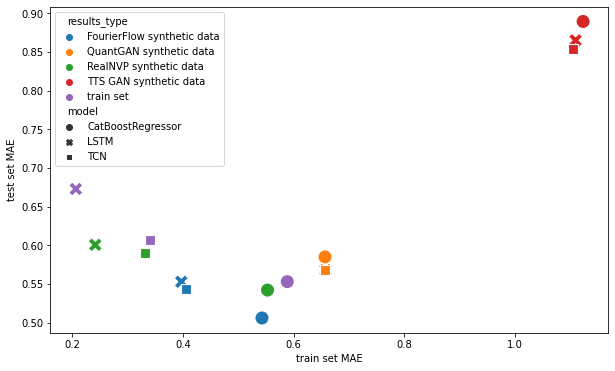

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 6))
# sns.scatterplot(data=results_agg[results_agg.index.get_level_values(1) != "TTS GAN synthetic data"], x="train", y="test", hue="results_type", style="model", s=200, ax=ax)
sns.scatterplot(data=results_agg, x="train", y="test", hue="results_type", style="model", s=200, ax=ax)
ax.set_xlabel("train set MAE")
ax.set_ylabel("test set MAE")
plt.show()

<AxesSubplot:xlabel='model', ylabel='test'>

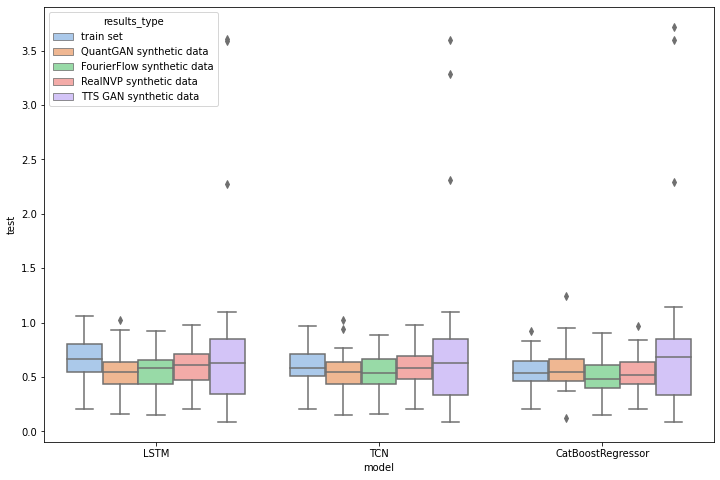

In [9]:
fig, ax = plt.subplots(1, figsize=(12, 8))
# sns.boxplot(data=results[results.results_type != "TTS GAN synthetic data"], x="model", y="test", hue="results_type", palette="pastel", ax=ax)
sns.boxplot(data=results, x="model", y="test", hue="results_type", palette="pastel", ax=ax)

# Gains

In [10]:
pure = results[results.results_type == "train set"]
gains = None
for synth_rt in (x for x in results.results_type.unique() if x != "train set"):
    synth_df = results[results.results_type == synth_rt]
    gain = (pure.groupby([pure.index, "model"]).mean() - synth_df.groupby([synth_df.index, "model"]).mean()) / pure.groupby([pure.index, "model"]).mean() * 100
    gain.index, gain["model"] = gain.index.get_level_values(0), gain.index.get_level_values(1)
    synth_rt = synth_rt.split(' ')[0]
    gain.rename(columns={"train": f"train_{synth_rt}", "test": f"test_{synth_rt}"}, inplace=True)
    gain["ts_id"] = gain.index
    if gains is None:
        gains = gain
    else:
        gains = gains.merge(gain, on=["model", "ts_id"])

gains = gains.merge(ts_info, on="ts_id")
gains

,train_QuantGAN,test_QuantGAN,model,ts_id,train_FourierFlow,test_FourierFlow,train_RealNVP,test_RealNVP,train_TTS,test_TTS,filename,length,uptrending_rate
0,-25.359317,-7.702188,CatBoostRegressor,0,13.731173,19.102516,7.887294,-3.721094,11.389167,24.804506,opgnw.us.txt,444,0.388262
1,-452.917246,13.225944,LSTM,0,-190.699120,21.758680,-53.633076,5.805466,-254.751789,43.517947,opgnw.us.txt,444,0.388262
2,-174.712055,-6.656926,TCN,0,-63.349125,7.544062,16.276788,-9.901998,-74.970216,31.472421,opgnw.us.txt,444,0.388262
3,-46.171290,-35.081594,CatBoostRegressor,1,1.515767,2.103172,-1.914459,-4.677944,18.358921,25.442742,dare.us.txt,905,0.431416
4,-359.395468,-4.562081,LSTM,1,-79.284111,17.142010,35.839085,17.204189,-164.045571,38.211520,dare.us.txt,905,0.431416
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-292.056333,16.174766,LSTM,22,-229.173623,19.159151,-197.403307,15.280111,-278.145289,19.452983,gfi.us.txt,6686,0.454899
68,-68.171537,6.112127,TCN,22,-38.748771,10.161713,-31.279030,7.843167,-61.985181,9.862136,gfi.us.txt,6686,0.454899
69,-22.044958,-15.695689,CatBoostRegressor,23,8.094375,4.170784,3.580549,-1.406702,-275.000730,-254.648610,hig.us.txt,5514,0.506258
70,-108.837226,-3.613279,LSTM,23,-35.121195,12.414262,-37.316492,9.391191,-537.811228,-209.447689,hig.us.txt,5514,0.506258


In [11]:
gains.groupby(["model"]).mean().drop(columns=["ts_id", "length", "uptrending_rate"])

,train_QuantGAN,test_QuantGAN,train_FourierFlow,test_FourierFlow,train_RealNVP,test_RealNVP,train_TTS,test_TTS
model,,,,,,,,
CatBoostRegressor,-11.467774,-3.922793,8.002651,9.125681,5.949239,1.937419,-116.037136,-122.419662
LSTM,-285.572307,15.242832,-126.946386,17.893221,-20.166764,9.966180,-366.026977,-98.197789
TCN,-98.427483,6.581370,-19.914785,10.929661,4.784293,2.638436,-202.160669,-105.481048


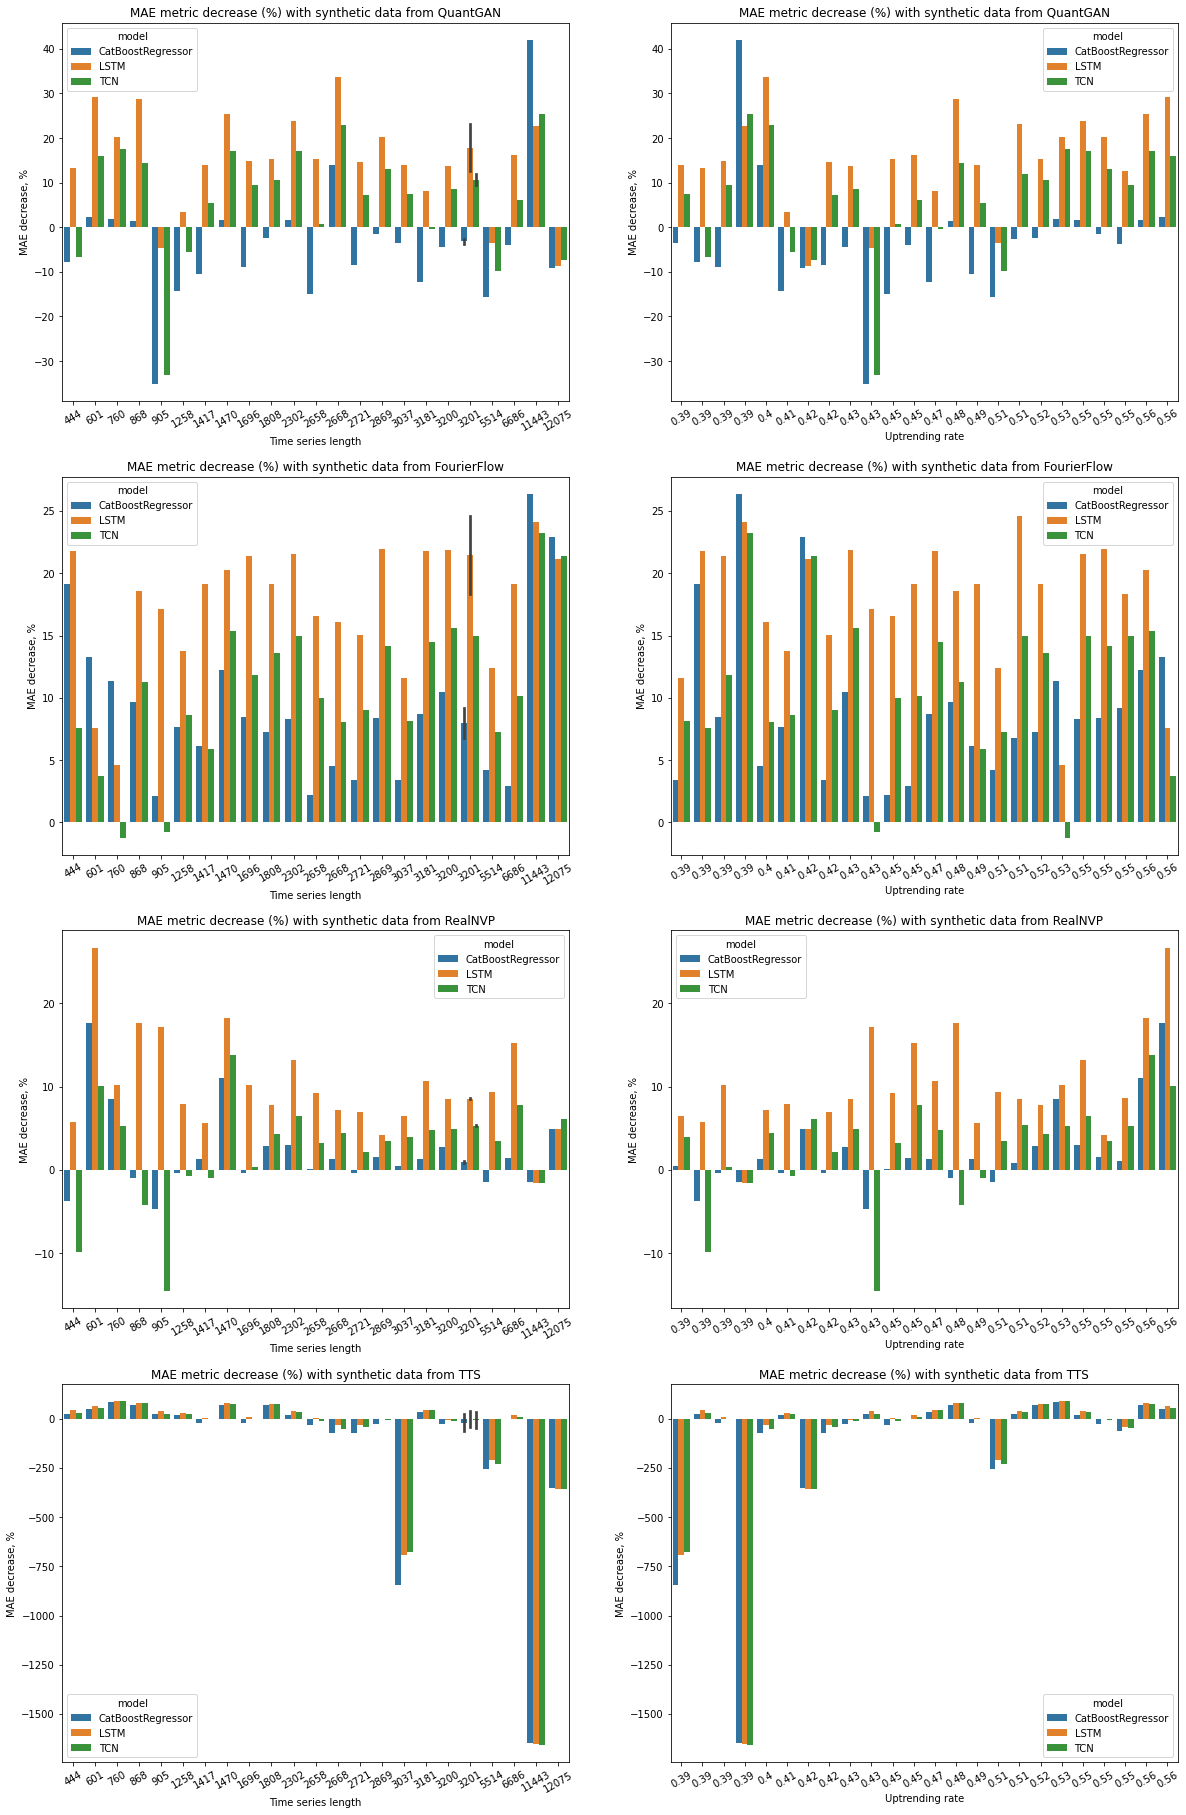

In [12]:
synth_models = ["QuantGAN", "FourierFlow", "RealNVP", "TTS"]
fig, axs = plt.subplots(len(synth_models), 2, figsize=(20, 8 * len(synth_models)))

for i in range(len(synth_models)):
    sns.barplot(data=gains, x="length", y=f"test_{synth_models[i]}", hue="model", ax=axs[i][0])
    axs[i][0].set_xlabel("Time series length")
    axs[i][0].set_xticklabels(sorted(gains["length"].unique()), rotation=30)
    axs[i][0].set_ylabel("MAE decrease, %")

    sns.barplot(data=gains, x="uptrending_rate", y=f"test_{synth_models[i]}", hue="model", ax=axs[i][1])
    axs[i][1].set_xlabel("Uptrending rate")
    axs[i][1].set_xticklabels(map(lambda x: round(x, 2), sorted(gains.uptrending_rate.unique())), rotation=30)
    axs[i][1].set_ylabel("MAE decrease, %")

    for j in range(2): axs[i][j].set_title(f"MAE metric decrease (%) with synthetic data from {synth_models[i]}")
    
plt.show()

In [13]:
length_intervals = [0, 1000, 5000, 13000]
temp = []
for i in range(1, len(length_intervals)):
    temp.append(gains[((gains.length > length_intervals[i - 1]) & (gains.length < length_intervals[i]))]\
        .groupby("model").mean())
    temp[- 1]["length"] = f"{length_intervals[i - 1]}-{length_intervals[i]}"
pd.concat(temp).drop(columns=["uptrending_rate", "ts_id"])

,train_QuantGAN,test_QuantGAN,train_FourierFlow,test_FourierFlow,train_RealNVP,test_RealNVP,train_TTS,test_TTS,length
model,,,,,,,,,
CatBoostRegressor,-23.079937,-7.441804,6.152635,11.101718,12.006110,3.367282,48.889308,51.474961,0-1000
LSTM,-319.720051,17.404497,-64.589099,13.919296,20.863652,15.533221,-75.463412,62.905488,0-1000
TCN,-141.645753,1.626106,-4.007949,4.101287,36.882509,-2.665364,3.381399,55.050960,0-1000
CatBoostRegressor,-10.922674,-4.679374,6.892583,7.141354,4.858513,1.753080,-48.881244,-62.907336,1000-5000
LSTM,-324.680329,16.812224,-166.225075,18.866459,-23.635664,8.898185,-368.399804,-31.516895,1000-5000
TCN,-100.717439,9.033425,-27.893156,11.980901,-0.356643,4.053301,-144.896162,-38.106536,1000-5000
CatBoostRegressor,1.003306,3.313148,14.477927,14.096863,2.468375,0.841363,-574.029785,-562.959161,5000-13000
LSTM,-96.232545,6.655528,-57.597908,19.210990,-58.446408,7.012361,-720.333332,-549.630240,5000-13000
TCN,-35.817310,3.580245,-9.879439,15.522977,-16.059971,3.962441,-673.830153,-558.800475,5000-13000
